# Empirical modelling of data



Here I will test modelling the multiband data as part of an empirical prior model. To illustrate and validate this I will carry out the following steps:
1. Model simulation distribution 
2. Model simulation distribution having made cut
3. Model simulation distribution with model for cuts
3. Model simulation distribution from map

In [3]:
import numpy as np
import pylab as plt
import seaborn as sns
%matplotlib inline

In [4]:
from astropy.table import Table

In [3]:
mock=Table.read('../../../test_files/lacey_07012015_MillGas.ALLVOLS_cat_PSW_COSMOS_test.fits')

In [4]:
mock[0:10]

DHALOID,GALAXYID,S100,S160,S250,S350,S500,APPUSO_TOT_EXT,APPGSO_TOT_EXT,APPRSO_TOT_EXT,APPISO_TOT_EXT,APPZSO_TOT_EXT,DEC,IS_CENTRAL,MHHALO,MSTARDOT,MSTARS_TOT,RA,Z_COS,Z_OBS
str22,str22,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float32,float32
7221000005,250660000005,0.184557,0.847295,1.00324,0.666443,0.30983,21.0851,19.9199,19.3745,19.1446,18.9669,2.52281435887,0.0,1.12367e+11,8.41508e+07,1.02091e+09,149.968831368,0.102633,0.100918
7354000005,252230000005,0.879098,2.2013,1.80466,0.997061,0.40618,20.3638,19.3247,18.8853,18.698,18.5506,1.09296587368,0.0,1.81679e+11,1.88512e+08,1.15188e+09,149.996199092,0.092121,0.0912445
4026000013,210160000013,0.0112136,0.0411177,0.0405248,0.0241011,0.0102681,25.039,23.1625,21.7082,21.1741,20.85,2.10696062174,0.0,2.84672e+11,2.00169e+06,6.09953e+09,149.137297107,0.376282,0.376532
4726000013,219730000013,0.0652038,0.208996,0.191553,0.110243,0.0459506,23.3759,22.8123,21.79,21.5169,21.3217,2.56423522875,0.0,2.80937e+11,3.34448e+08,1.60865e+09,150.92582623,0.376829,0.377374
5536000013,230270000013,0.103659,0.455567,0.496569,0.309403,0.13604,22.8201,22.3489,21.3669,21.1046,20.9246,2.16826441305,0.0,1.81664e+11,5.8204e+08,2.28481e+09,149.524681469,0.377186,0.377635
5762000013,233190000013,0.136709,0.615261,0.677913,0.424214,0.187012,22.8012,22.2651,21.2245,20.9151,20.6908,1.88389672817,0.0,1.76046e+11,6.97228e+08,3.16073e+09,149.729887985,0.383715,0.3851
9150000013,272530000013,0.0201797,0.105251,0.130986,0.0878964,0.0408579,23.9817,23.5002,22.5123,22.2561,22.0729,2.41002832928,0.0,8.80211e+10,1.92794e+08,7.69563e+08,149.891553543,0.381552,0.382695
4424000012,215640000012,0.0270184,0.146568,0.192646,0.136105,0.0665875,23.3157,22.8147,22.039,21.8566,21.7233,1.40785718228,0.0,1.55454e+11,2.51134e+08,6.29514e+08,150.436258903,0.327132,0.325931
24026571,1840000011,39.481,67.4472,45.2025,23.0549,8.96614,23.275,21.9669,20.7596,20.2263,19.9311,2.15883520338,0.0,2.30369e+11,5.59299e+09,2.42265e+10,149.563597856,0.292259,0.293412


In [5]:
import pystan

## Gaussian Mixture model

In [130]:
model="""
data {
  int N;
  int D;
  vector[D] y[N];
  int n_groups;
}
parameters {
  ordered[n_groups] mu_S250;
  vector[D-1] mu_other[n_groups];
  cholesky_factor_corr[D] L[n_groups];
  simplex[n_groups] Theta;
  vector<lower=0>[D] L_sigma[n_groups];

}
transformed parameters {
  vector[D] mu_all[n_groups];
  for (n in 1:n_groups){
  mu_all[n,1]=mu_S250[n];
  for (d in 1:D-1){
  mu_all[n,d+1]=mu_other[n,d];
  }
  }
  

  
  


}
model {
  vector[n_groups] contributions;
  matrix[D, D] L_Sigma[n_groups];
  // priors
  mu_S250~normal(0, 10);
  
  Theta ~ dirichlet(rep_vector(2.0, n_groups));
  for(n in 1:n_groups) {
  L[n] ~ lkj_corr_cholesky(4);
  L_sigma[n] ~ cauchy(0, 2.5);
  L_Sigma[n] = diag_pre_multiply(L_sigma[n], L[n]);
  for (i in 1:D-1){
  mu_other[n,i] ~ normal(0, 10);
  }
  }
  // likelihood
  for(i in 1:N) {
    for(k in 1:n_groups) {
      
      contributions[k] = log(Theta[k]) + multi_normal_cholesky_lpdf(y[i] | mu_all[k], L_Sigma[k]);
    }
    target += log_sum_exp(contributions);
  }
}
generated quantities {
vector[D] yrep[2];
matrix[D, D] L_Sigma[n_groups];
L_Sigma[1] = diag_pre_multiply(L_sigma[1], L[1]);
for(i in 1:2){
yrep[i]=multi_normal_cholesky_rng(mu_all[1], L_Sigma[1]);
}


}


"""

In [131]:
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e64f93d11b43efeb41e87e72a51be1f9 NOW.


## Select sources that have finite flux values in 100, 250, 350 and 500 $\mathrm{\mu m}$

In [16]:
ind_true=np.isfinite(np.log10(mock['S100'][0:200])) & np.isfinite(np.log10(mock['S250'][0:200])) & np.isfinite(np.log10(mock['S350'][0:200])) & np.isfinite(np.log10(mock['S500'][0:200]))

/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


In [17]:
y_true=np.vstack((np.log10(mock['S100'][0:200])[ind_true],np.log10(mock['S250'][0:200])[ind_true],np.log10(mock['S350'][0:200])[ind_true],np.log10(mock['S500'][0:200])[ind_true]))

/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


In [168]:
data={'N':ind_true.sum(),
      'D':4,
      'y':y_true.T,
      'n_groups':1}

In [152]:
fit=sm.sampling(data=data, iter=2000)

In [153]:
fit

Inference for Stan model: anon_model_e64f93d11b43efeb41e87e72a51be1f9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_S250[0]      -1.79    0.01   0.11  -2.03  -1.86  -1.79  -1.72  -1.59     97   1.03
mu_other[0,0]   -1.16  8.8e-3   0.08  -1.32  -1.21  -1.15   -1.1   -1.0     85   1.03
mu_other[0,1]   -1.35  8.4e-3   0.08  -1.52   -1.4  -1.35   -1.3  -1.21     86   1.03
mu_other[0,2]    -1.7  8.1e-3   0.08  -1.86  -1.75   -1.7  -1.65  -1.56     88   1.03
L[0,0,0]          1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   4000    nan
L[0,1,0]         0.92  1.8e-3   0.01    0.9   0.91   0.92   0.93   0.94     46   1.09
L[0,2,0]         0.88  2.6e-3   0.02   0.84   0.86   0.87   0.89   0.91     46   1.09
L[0,3,0]         0.84  3.3e-3   0.02    0.8   0.82   0.84   0.85   0.88     46   1.09
L[0,0,1]          0.0     0.0    0.0 

In [154]:
samples=fit.extract()

/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


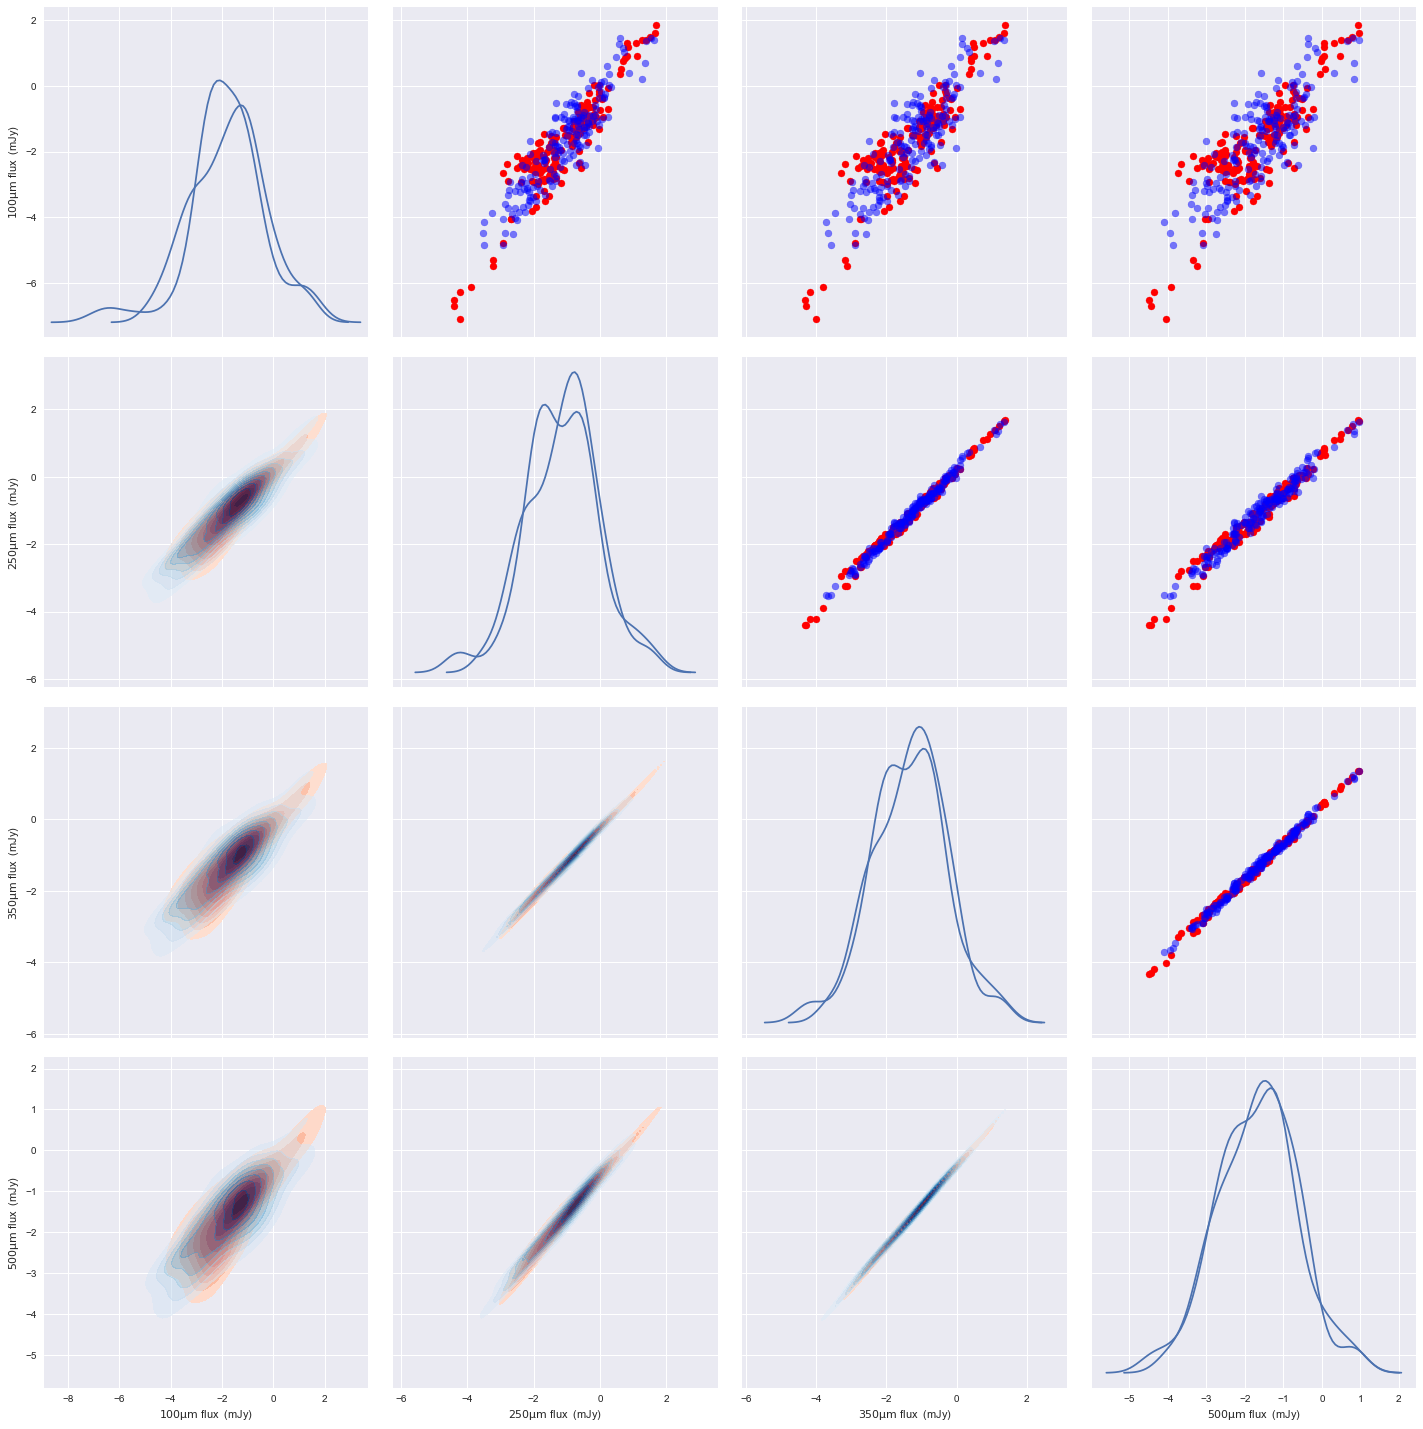

In [155]:
import pandas as pd
labels=[r'$100\mathrm{\mu m}$ flux  (mJy)',r'$250\mathrm{\mu m}$ flux  (mJy)',r'$350\mathrm{\mu m}$ flux  (mJy)',r'$500\mathrm{\mu m}$ flux  (mJy)']
df = pd.DataFrame(y.T,columns=labels)
g = sns.PairGrid(df,size=5)
g.map_diag(sns.kdeplot,c='Red')
g.map_lower(sns.kdeplot, cmap="Reds",alpha=1.0,n_levels=10,normed=True, shade=True,shade_lowest=False)
g.map_upper(plt.scatter, color="Red",alpha=1.0)

df = pd.DataFrame(samples['yrep'][:,0,:],columns=labels)
g.data=df
g.map_diag(sns.kdeplot,c='Blue')
g.map_lower(sns.kdeplot, cmap="Blues",alpha=0.5,n_levels=10,normed=True, shade=True,shade_lowest=False)
g.map_upper(plt.scatter, color="Blue",alpha=0.5)


(array([   12.,    64.,   243.,   641.,   956.,  1044.,   675.,   275.,
           81.,     9.]),
 array([-6.70379782, -5.73487029, -4.76594277, -3.79701525, -2.82808773,
        -1.8591602 , -0.89023268,  0.07869484,  1.04762236,  2.01654988,
         2.98547741]),
 <a list of 10 Patch objects>)

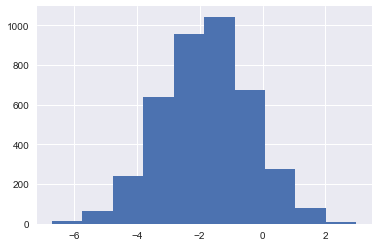

In [156]:
plt.hist(samples['yrep'][:,0,0])

## Now lets do the same, but with a cut at of 0.1 $\mathrm{m Jy}$

In [41]:
nsrc=1000
ind=(np.log10(mock['S100'][0:nsrc])> -1) & np.isfinite(np.log10(mock['S250'][0:nsrc])) & np.isfinite(np.log10(mock['S350'][0:nsrc])) & np.isfinite(np.log10(mock['S500'][0:nsrc]))

/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


In [42]:
y=np.vstack((np.log10(mock['S100'][0:nsrc])[ind],np.log10(mock['S250'][0:nsrc])[ind],np.log10(mock['S350'][0:nsrc])[ind],np.log10(mock['S500'][0:nsrc])[ind]))

/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


In [43]:
data={'N':ind.sum(),
      'D':4,
      'y':y.T,
      'n_groups':1}

In [44]:
fit=sm.sampling(data=data, iter=2000)

RuntimeError: variable does not exist; processing stage=data initialization; variable name=S1_cut; base type=double

In [161]:
fit

Inference for Stan model: anon_model_e64f93d11b43efeb41e87e72a51be1f9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_S250[0]      -0.04  7.2e-3   0.12  -0.26  -0.12  -0.04   0.04    0.2    253   1.01
mu_other[0,0]    0.18  5.9e-3   0.09   0.02   0.12   0.18   0.24   0.37    212   1.01
mu_other[0,1]   -0.09  5.8e-3   0.08  -0.25  -0.15  -0.09  -0.04   0.09    217   1.01
mu_other[0,2]   -0.49  5.7e-3   0.08  -0.65  -0.55  -0.49  -0.43  -0.31    222   1.01
L[0,0,0]          1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   4000    nan
L[0,1,0]         0.88  2.6e-3   0.03   0.81   0.86   0.88    0.9   0.93    148   1.03
L[0,2,0]         0.83  3.8e-3   0.05   0.72    0.8   0.83   0.86    0.9    146   1.03
L[0,3,0]         0.79  4.6e-3   0.06   0.66   0.75   0.79   0.83   0.87    147   1.03
L[0,0,1]          0.0     0.0    0.0 

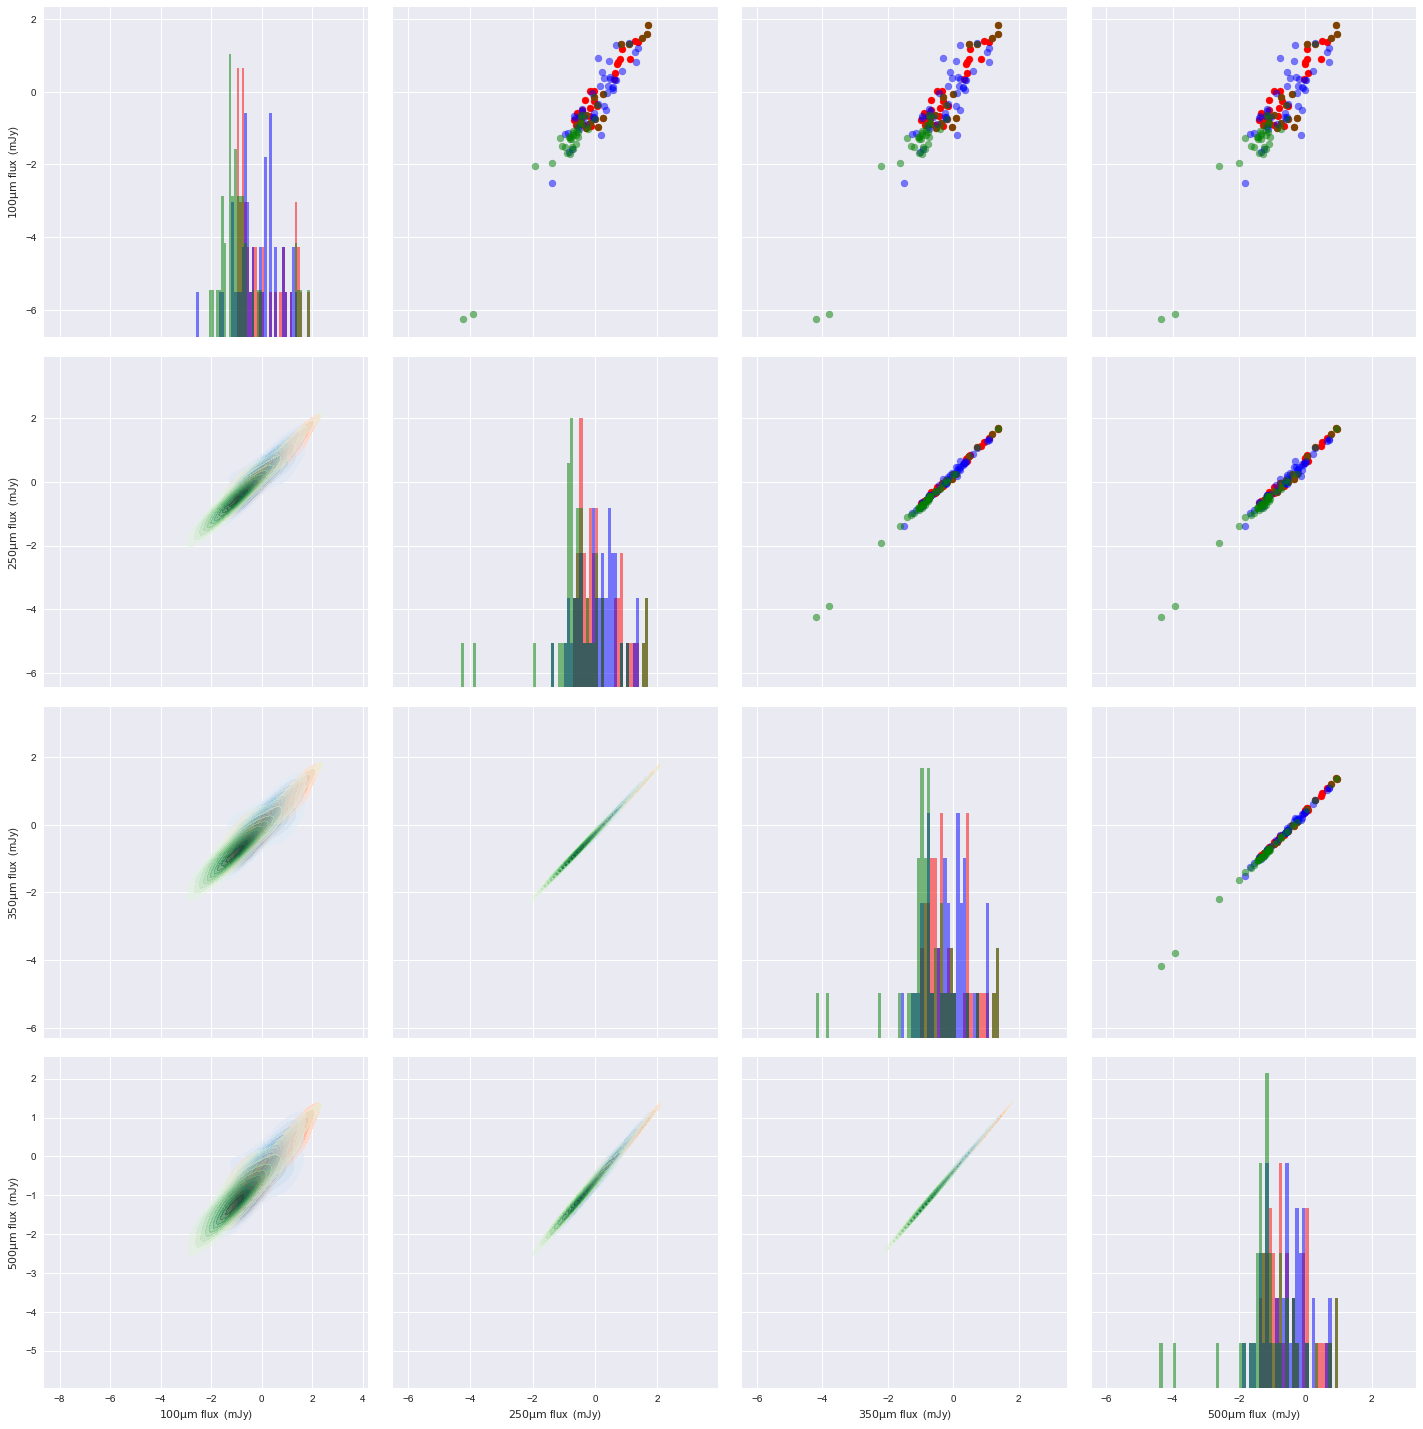

In [184]:
samples=fit.extract()
labels=[r'$100\mathrm{\mu m}$ flux  (mJy)',r'$250\mathrm{\mu m}$ flux  (mJy)',r'$350\mathrm{\mu m}$ flux  (mJy)',r'$500\mathrm{\mu m}$ flux  (mJy)']
df = pd.DataFrame(y.T,columns=labels)
g = sns.PairGrid(df,size=5)
g.map_diag(plt.hist,facecolor='Red',alpha=0.5,bins=np.arange(-6,3,0.1),normed=True)
g.map_lower(sns.kdeplot, cmap="Reds",alpha=1.0,n_levels=10,normed=True, shade=True,shade_lowest=False)
g.map_upper(plt.scatter, color="Red",alpha=1.0)

df = pd.DataFrame(samples['yrep'][:,1,:],columns=labels)
g.data=df
g.map_diag(plt.hist,facecolor='Blue',alpha=0.5,bins=np.arange(-6,3,0.1),normed=True)
g.map_lower(sns.kdeplot, cmap="Blues",alpha=0.5,n_levels=10,normed=True, shade=True,shade_lowest=False)
g.map_upper(plt.scatter, color="Blue",alpha=0.5)

df = pd.DataFrame(y_true.T,columns=labels)
g.data=df
g.map_diag(plt.hist,facecolor='Green', alpha=0.5, bins=np.arange(-6,3,0.1),normed=True)
g.map_lower(sns.kdeplot, cmap="Greens",alpha=0.5,n_levels=10,normed=True, shade=True,shade_lowest=False)
g.map_upper(plt.scatter, color="Green",alpha=0.5)


In [69]:
model_cut="""
data {
  int N;
  int D;
  vector[D] y[N];
  int n_groups;
  real S1_cut;
}
parameters {
  ordered[n_groups] mu_1;
  vector[D-1] mu_other[n_groups];
  cholesky_factor_corr[D] L[n_groups];
  simplex[n_groups] Theta;
  vector<lower=0>[D] L_sigma[n_groups];
  vector<lower=-9,upper=3>[D] y_true[N];
}

  


model {
  vector[n_groups] contributions;
  matrix[D, D] L_Sigma[n_groups];
  vector[D] mu_all[n_groups];

  // priors
  mu_1~normal(0, 10);
  
  Theta ~ dirichlet(rep_vector(2.0, n_groups));
  for(n in 1:n_groups) {
  mu_all[n,1]=mu_1[n];
  L[n] ~ lkj_corr_cholesky(4);
  L_sigma[n] ~ cauchy(0, 2.5);
  L_Sigma[n] = diag_pre_multiply(L_sigma[n], L[n]);
  for (i in 1:D-1){
  mu_other[n,i] ~ normal(0, 10);
  mu_all[n,i+1]=mu_other[n,i];
  }
  }
  for (s in 1:N){
    y[s,1]~normal(y_true[s,1],0.1)T[S1_cut,];
    for (i in 1:D-1){
    y[s,i+1]~normal(y_true[s,i+1],0.1);
  }
  }
  print("lp before =", target());
  // likelihood
  for(i in 1:N) {
    for(k in 1:n_groups) {
      
      contributions[k] = log(Theta[k]) + multi_normal_cholesky_lpdf(y_true[i] | mu_all[k], L_Sigma[k]);
    }
    target += log_sum_exp(contributions);
  }
  print("lp after =", target());
  
}
generated quantities {
vector[D] yrep[2];
matrix[D, D] L_Sigma[n_groups];
vector[D] mu_all[n_groups];
for(n in 1:n_groups) {
mu_all[n,1]=mu_1[n];
for (d in 1:D-1){
mu_all[n,d+1]=mu_other[n,d];
}}


L_Sigma[1] = diag_pre_multiply(L_sigma[1], L[1]);
for(i in 1:2){
yrep[i]=multi_normal_cholesky_rng(mu_all[1], L_Sigma[1]);
}


}


"""

In [70]:
sm = pystan.StanModel(model_code=model_cut)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8113135e9390d665d577dffc4ec4da0b NOW.


In [71]:
data={'N':ind.sum(),
      'D':4,
      'y':y.T,
      'n_groups':1,
      'S1_cut':-1.0}

In [72]:
ind.sum()

196

In [73]:
fit=sm.sampling(data=data, iter=2000)

RuntimeError: lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

lp before =inf
lp after =inf

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.



Initialization between (-2, 2) failed after 100 attempts. 
 Try specifying initial values, reducing ranges of constrained values, or reparameterizing the model.


In [40]:
fit

Inference for Stan model: anon_model_a1f413cb8abbab543dbd84f0185886c1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_1[0]         -0.06  2.8e-3   0.12  -0.29  -0.14  -0.06   0.02   0.19   1898    1.0
mu_other[0,0]    0.18  2.1e-3   0.09   0.02   0.13   0.19   0.24   0.36   1668    1.0
mu_other[0,1]   -0.09  2.1e-3   0.09  -0.25  -0.15  -0.09  -0.03   0.09   1664    1.0
mu_other[0,2]   -0.48  2.1e-3   0.09  -0.65  -0.54  -0.48  -0.43  -0.32   1668    1.0
L[0,0,0]          1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   4000    nan
L[0,1,0]         0.87  1.0e-3   0.04   0.76   0.84   0.87    0.9   0.93   1725    1.0
L[0,2,0]         0.82  1.4e-3   0.05   0.69   0.78   0.82   0.86    0.9   1644    1.0
L[0,3,0]         0.78  1.6e-3   0.06   0.63   0.74   0.78   0.82   0.88   1716    1.0
L[0,0,1]          0.0     0.0    0.0 

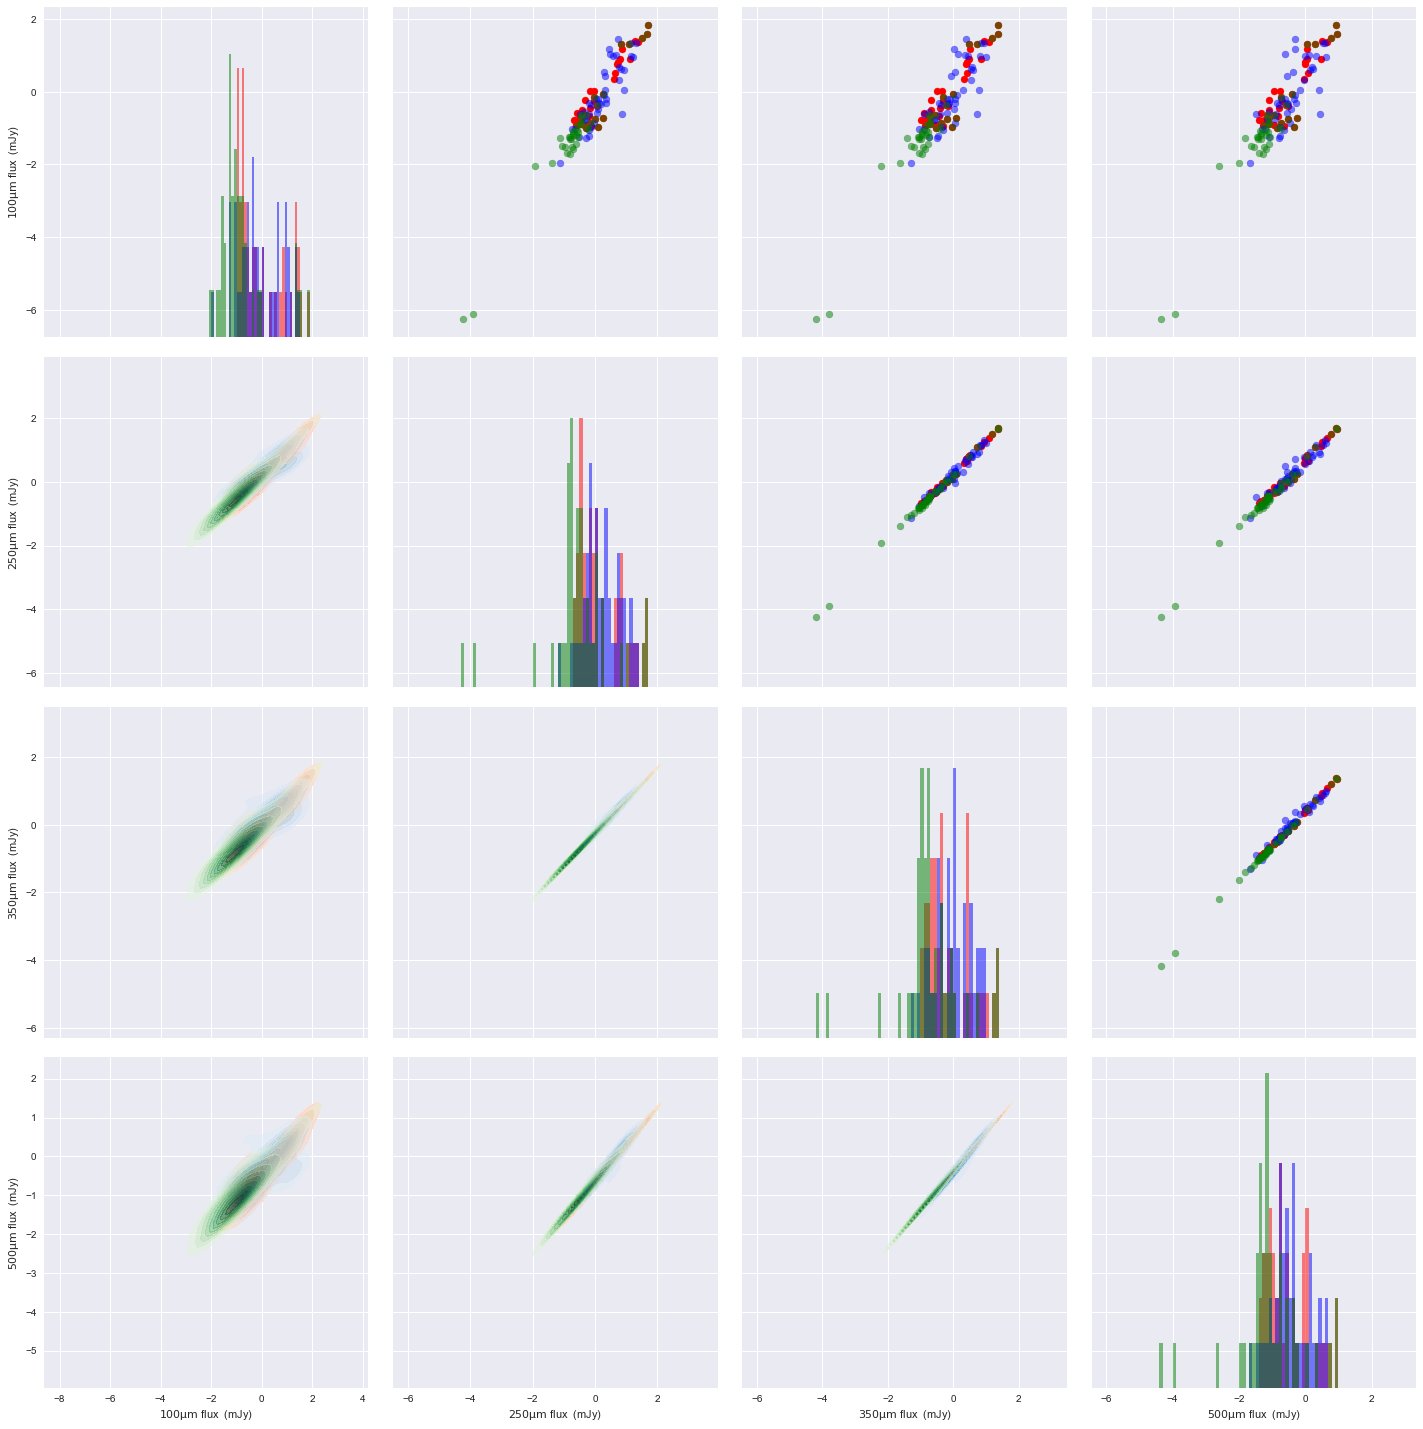

In [18]:
import pandas as pd

samples=fit.extract()
labels=[r'$100\mathrm{\mu m}$ flux  (mJy)',r'$250\mathrm{\mu m}$ flux  (mJy)',r'$350\mathrm{\mu m}$ flux  (mJy)',r'$500\mathrm{\mu m}$ flux  (mJy)']
df = pd.DataFrame(y.T,columns=labels)
g = sns.PairGrid(df,size=5)
g.map_diag(plt.hist,facecolor='Red',alpha=0.5,bins=np.arange(-6,3,0.1),normed=True)
g.map_lower(sns.kdeplot, cmap="Reds",alpha=1.0,n_levels=10,normed=True, shade=True,shade_lowest=False)
g.map_upper(plt.scatter, color="Red",alpha=1.0)

df = pd.DataFrame(samples['yrep'][:,1,:],columns=labels)
g.data=df
g.map_diag(plt.hist,facecolor='Blue',alpha=0.5,bins=np.arange(-6,3,0.1),normed=True)
g.map_lower(sns.kdeplot, cmap="Blues",alpha=0.5,n_levels=10,normed=True, shade=True,shade_lowest=False)
g.map_upper(plt.scatter, color="Blue",alpha=0.5)

df = pd.DataFrame(y_true.T,columns=labels)
g.data=df
g.map_diag(plt.hist,facecolor='Green', alpha=0.5, bins=np.arange(-6,3,0.1),normed=True)
g.map_lower(sns.kdeplot, cmap="Greens",alpha=0.5,n_levels=10,normed=True, shade=True,shade_lowest=False)
g.map_upper(plt.scatter, color="Green",alpha=0.5)


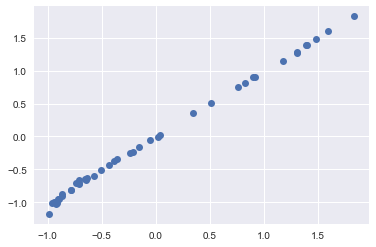

In [22]:
plt.plot(y[0,:],np.median(samples['y_true'][:,:,0],axis=0), 'o')

In [44]:
sig=np.array([[2,1.5],[1.5,2]])

In [45]:
points=np.exp(np.random.multivariate_normal(np.array([np.log(0.1),np.log(0.1)]), sig,size=1000))

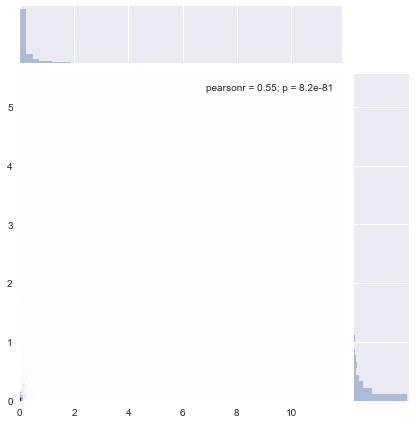

In [46]:
sns.jointplot(points[:,0],points[:,1],kind='hex')

In [12]:
points.shape

(100, 2)